In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Initializing Dependencies

import os
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.optimizers import RMSprop

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

from tensorflow import keras
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [ ]:
#Setting Directories
train_ampalaya_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/train/Ampalaya')
train_kangkong_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/train/Kangkong')
train_okra_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/train/Okra')
train_raddish_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/train/Raddish')
train_sitao_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/train/Sitao')

test_ampalaya_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/test/Ampalaya')
test_kangkong_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/test/Kangkong')
test_okra_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/test/Okra')
test_raddish_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/test/Raddish')
test_sitao_dir=os.path.join('/content/gdrive/MyDrive/SinigangMix/test/Sitao')

train_dir = '/content/gdrive/MyDrive/SinigangMix/train'
validation_dir = '/content/gdrive/MyDrive/SinigangMix/test'
testreal = '/content/gdrive/MyDrive/SinigangMix/testreal'

In [ ]:
#Transfer Learning. Using InceptionV3 CNN to augment our own CNN

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-12-21 12:31:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   131MB/s    in 0.6s    

2020-12-21 12:31:27 (131 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 17, 17, 768)


In [ ]:
##Appending our output DNN to the InceptionV3 CNN

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)                  
x = layers.Dense(5, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

In [ ]:
#Pre-processing

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=100,
    target_size=(300, 300), #,3
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=100,
    target_size=(300, 300),
    class_mode='categorical'
)

testreal_datagen = ImageDataGenerator(rescale=1./255)
testreal_generator = testreal_datagen.flow_from_directory(
    testreal,
    target_size=(300, 300),
    class_mode='categorical'
)

Found 4088 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 0 images belonging to 0 classes.


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=40,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=15,
      verbose=2)

Epoch 1/15
40/40 - 2146s - loss: 3.5193 - accuracy: 0.6497 - val_loss: 0.3654 - val_accuracy: 0.8767
Epoch 2/15
40/40 - 41s - loss: 0.5469 - accuracy: 0.8947 - val_loss: 0.0385 - val_accuracy: 0.9887
Epoch 3/15
40/40 - 41s - loss: 0.3082 - accuracy: 0.9456 - val_loss: 2.0146 - val_accuracy: 0.7360
Epoch 4/15
40/40 - 41s - loss: 0.4018 - accuracy: 0.9536 - val_loss: 0.4892 - val_accuracy: 0.8527
Epoch 5/15
40/40 - 41s - loss: 0.0195 - accuracy: 0.9942 - val_loss: 0.0158 - val_accuracy: 0.9940
Epoch 6/15
40/40 - 41s - loss: 0.3936 - accuracy: 0.9644 - val_loss: 0.0481 - val_accuracy: 0.9807
Epoch 7/15
40/40 - 41s - loss: 0.1413 - accuracy: 0.9762 - val_loss: 0.0133 - val_accuracy: 0.9980
Epoch 8/15
40/40 - 41s - loss: 0.1465 - accuracy: 0.9789 - val_loss: 0.0167 - val_accuracy: 0.9940
Epoch 9/15
40/40 - 41s - loss: 0.1448 - accuracy: 0.9814 - val_loss: 0.0181 - val_accuracy: 0.9960
Epoch 10/15
40/40 - 41s - loss: 0.1961 - accuracy: 0.9767 - val_loss: 0.0212 - val_accuracy: 0.9933
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


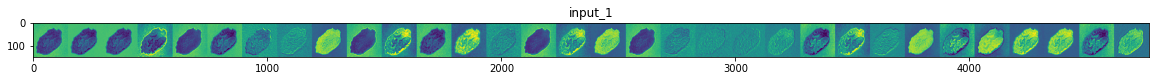

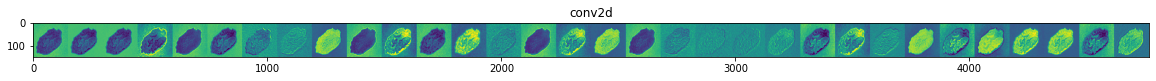

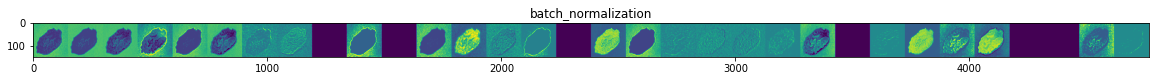

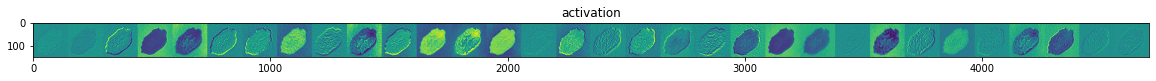

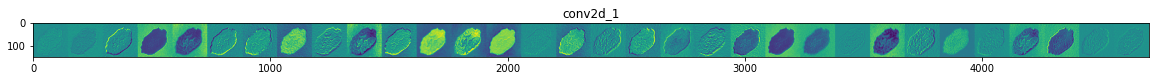

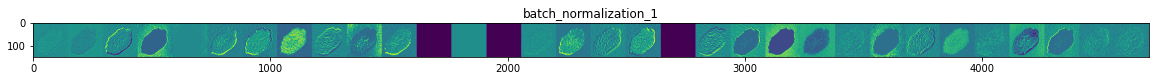

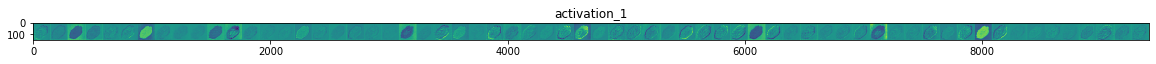

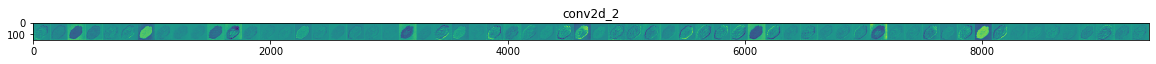

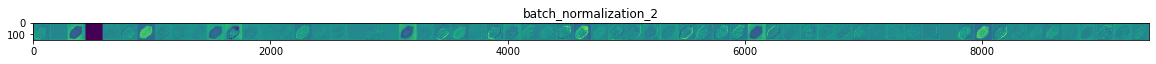

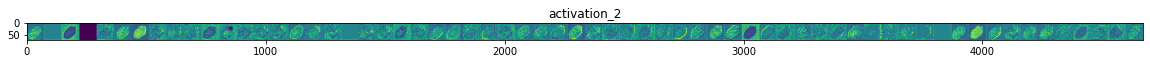

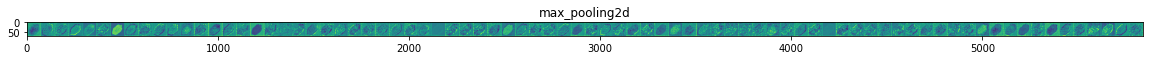

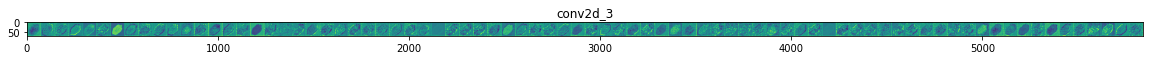

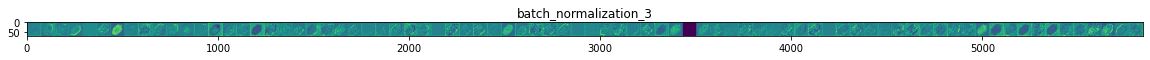

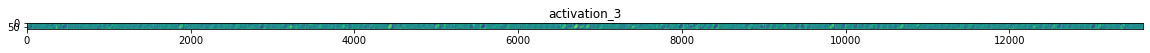

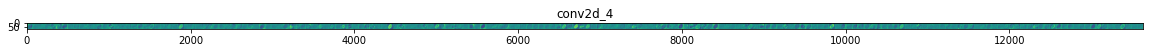

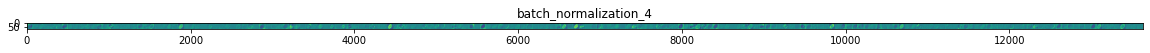

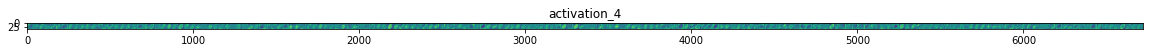

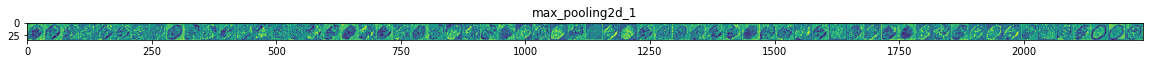

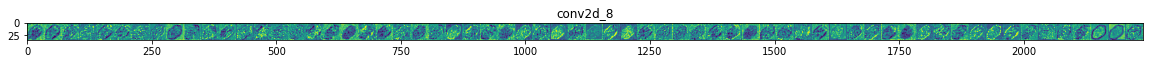

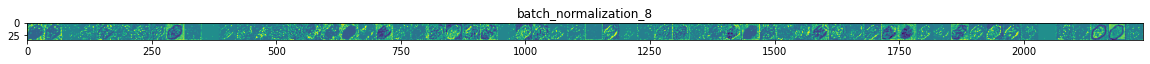

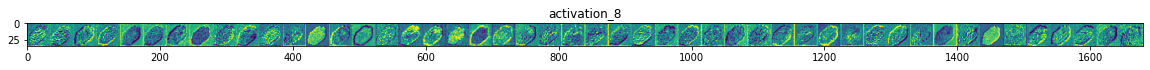

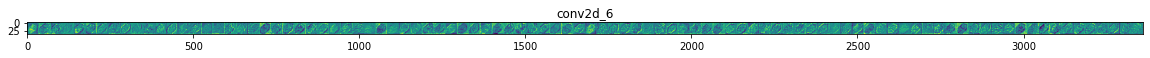

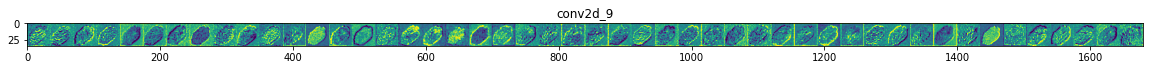

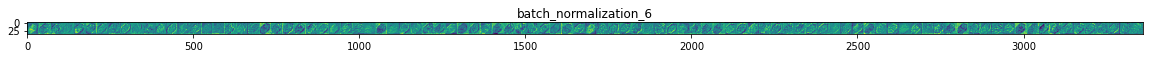

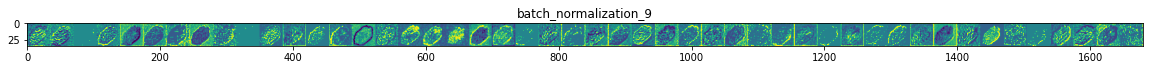

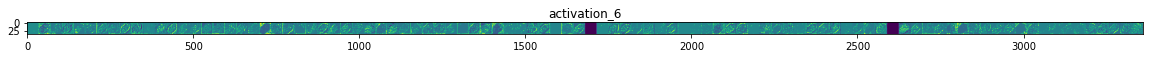

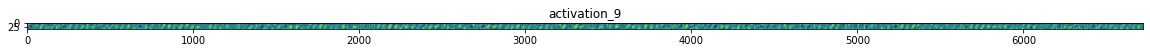

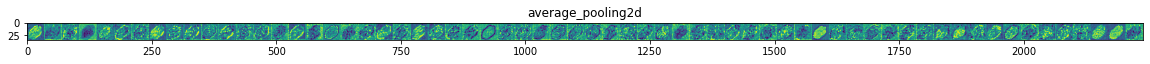

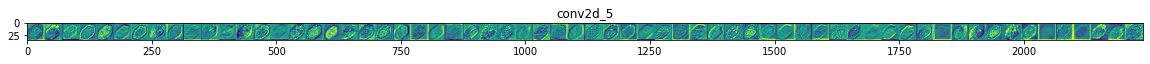

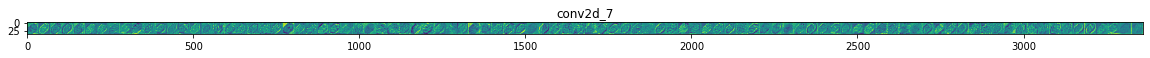

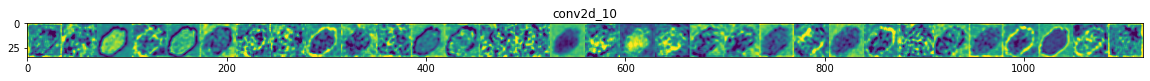

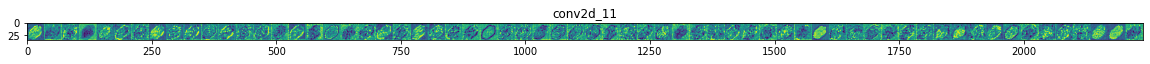

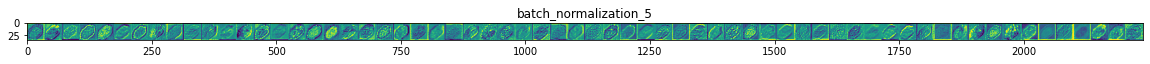

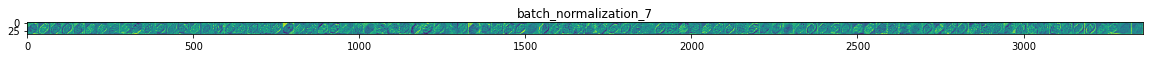

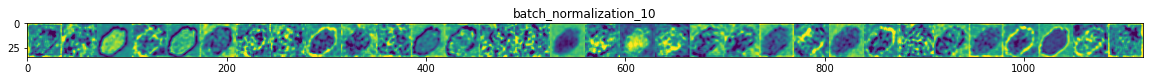

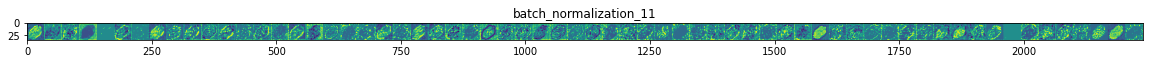

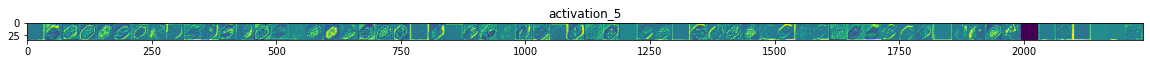

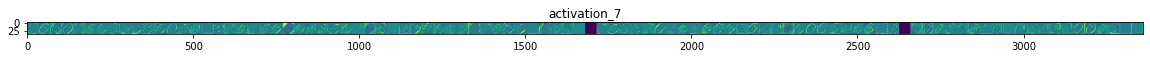

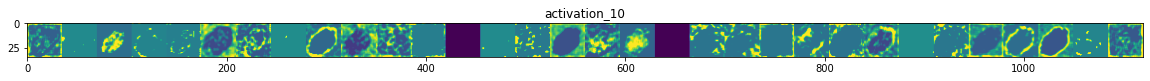

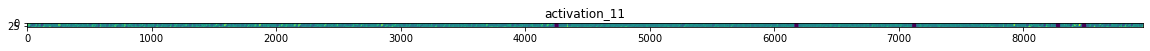

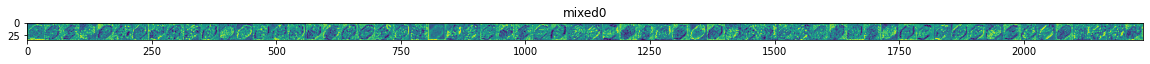

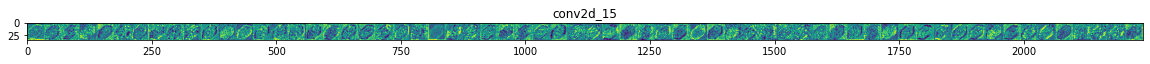

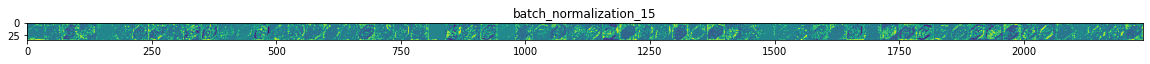

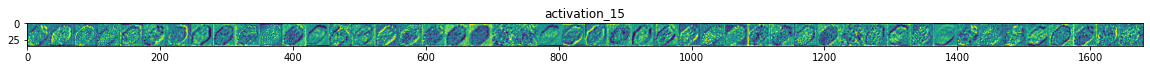

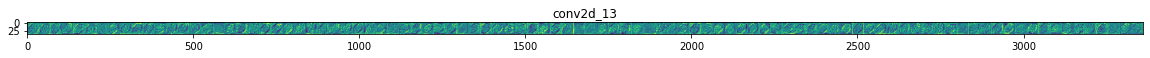

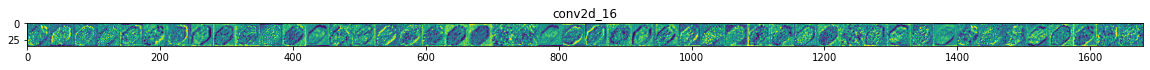

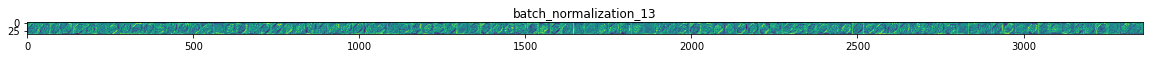

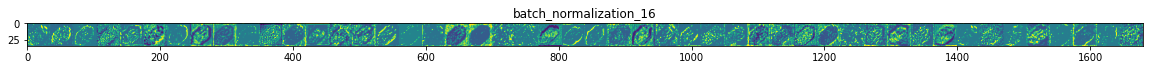

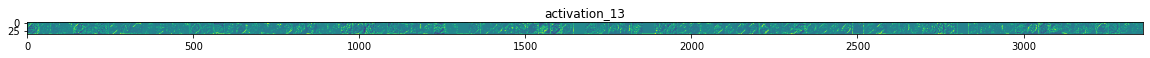

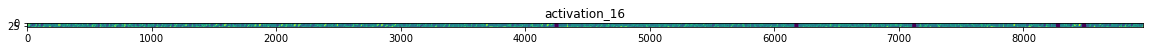

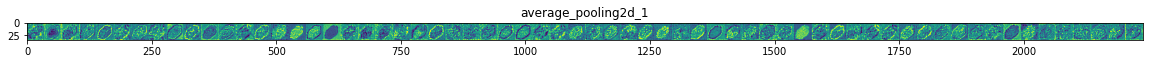

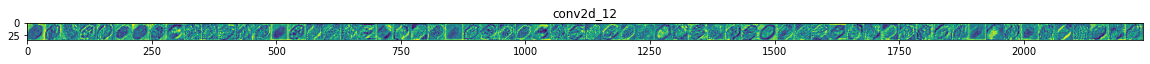

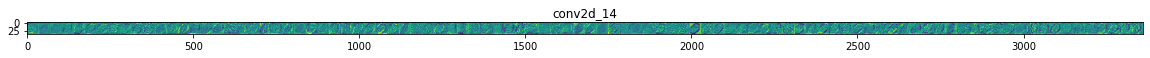

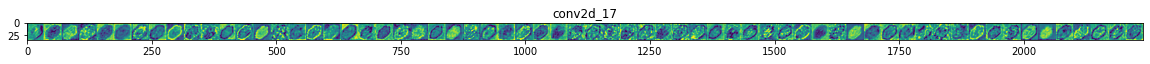

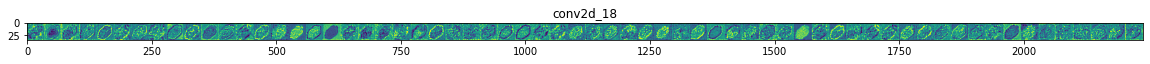

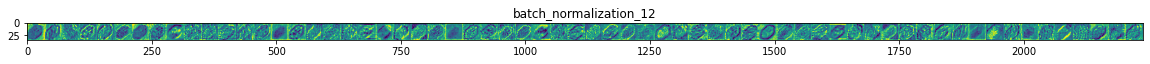

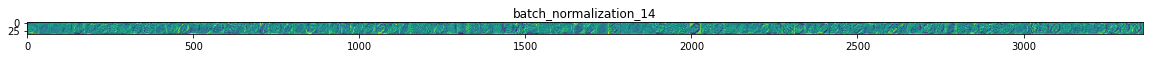

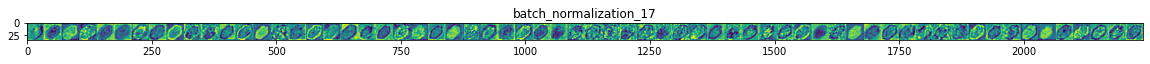

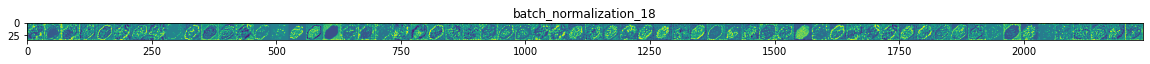

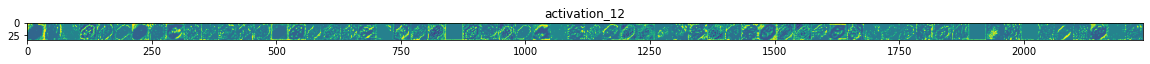

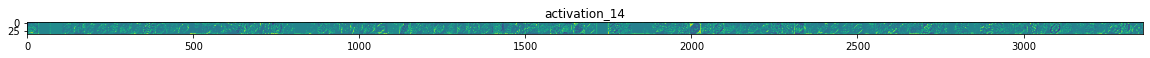

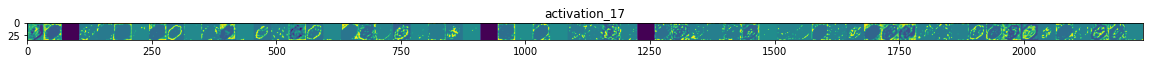

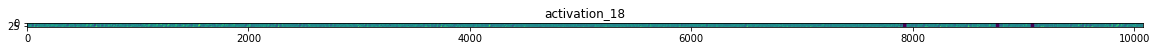

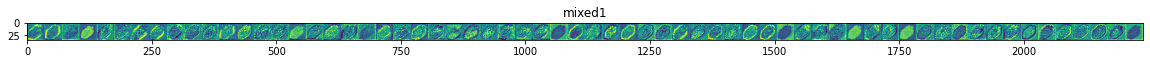

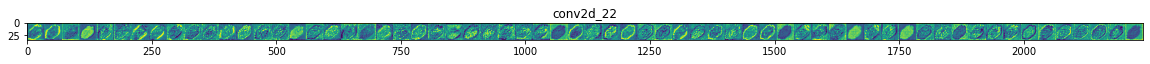

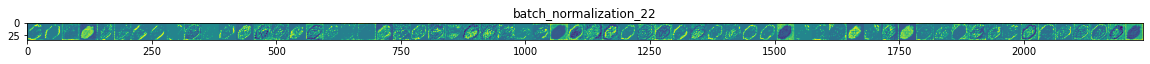

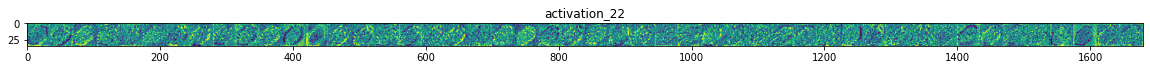

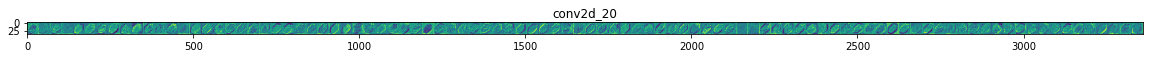

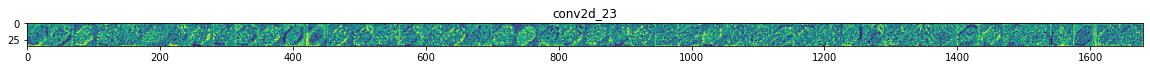

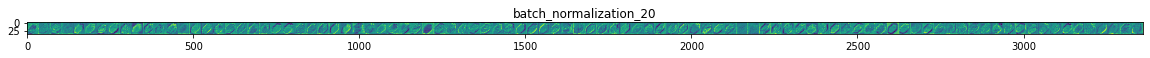

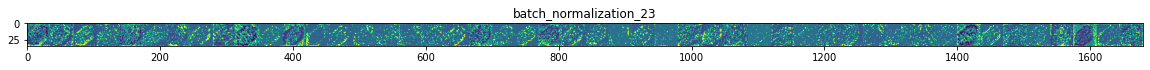

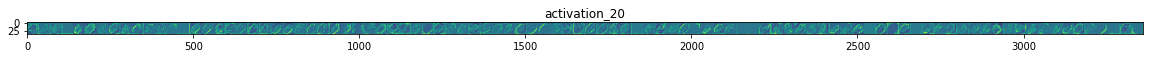

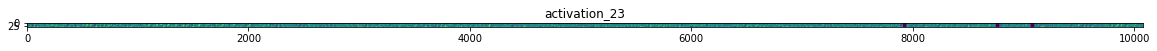

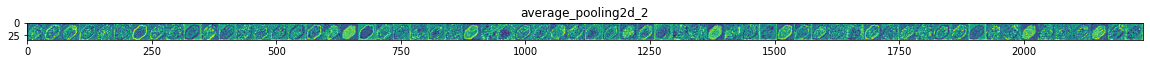

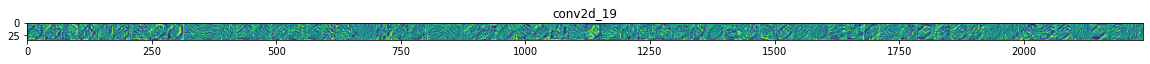

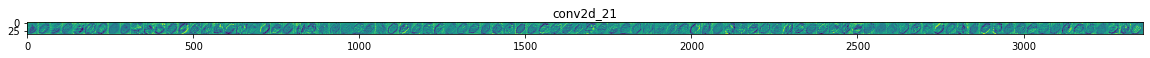

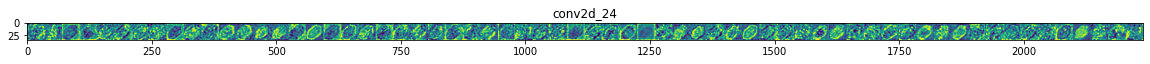

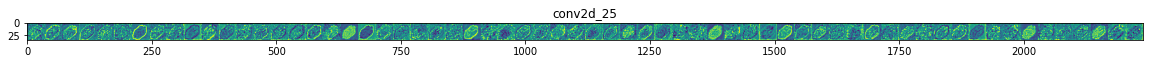

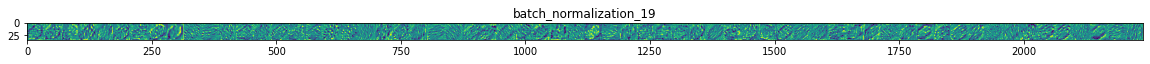

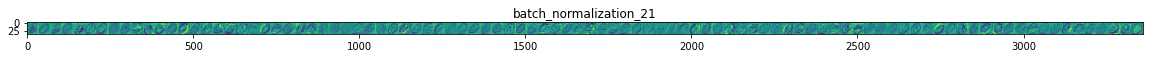

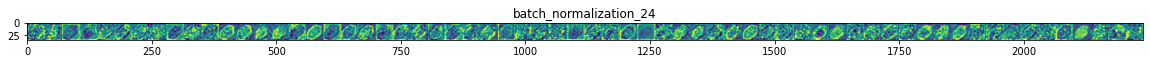

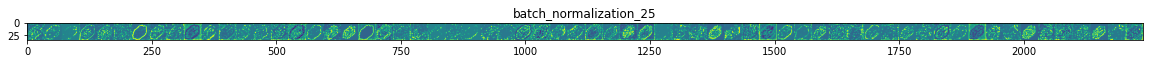

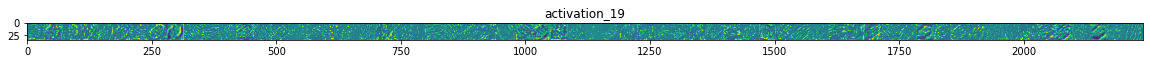

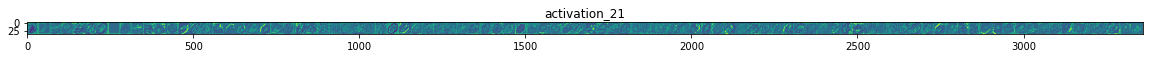

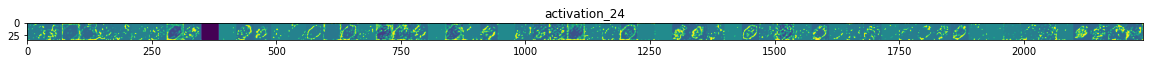

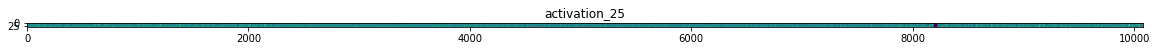

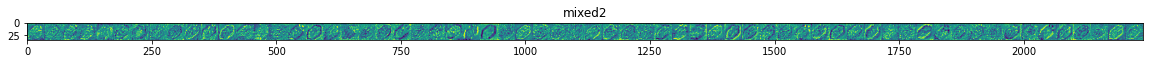

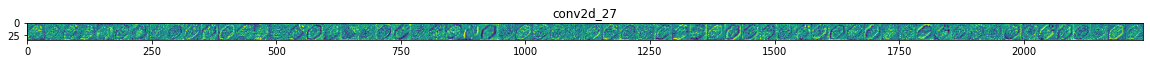

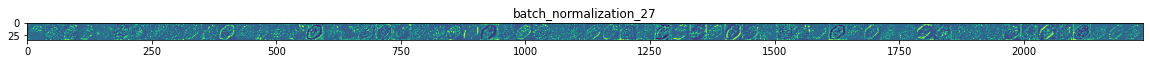

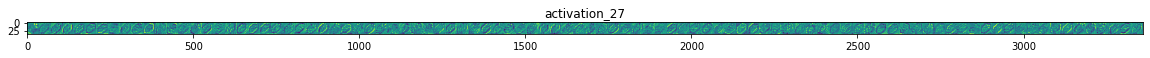

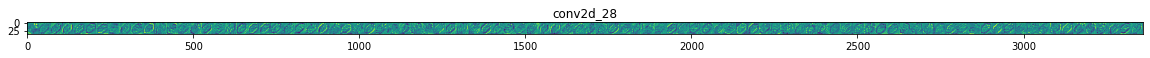

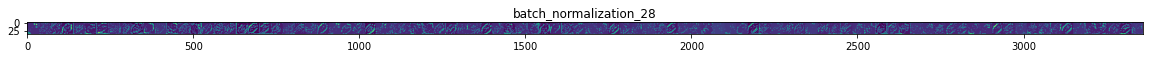

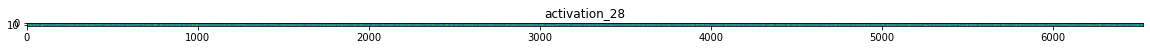

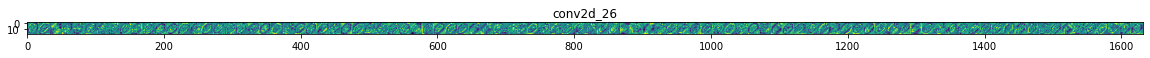

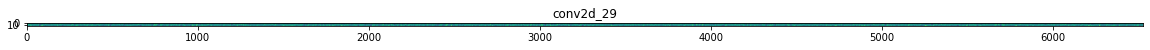

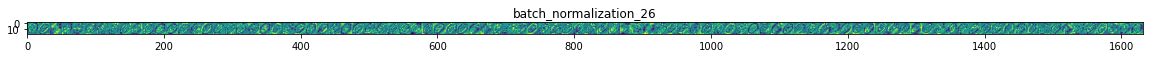

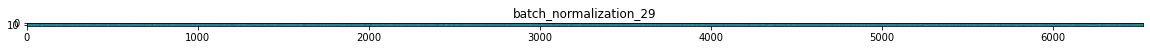

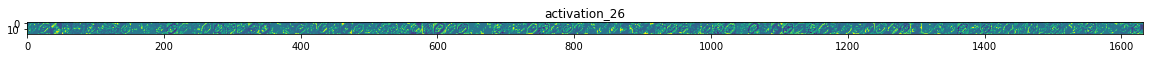

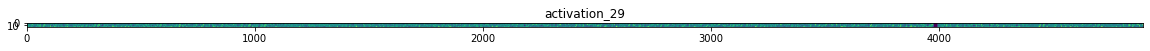

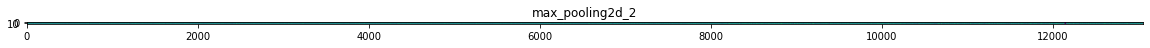

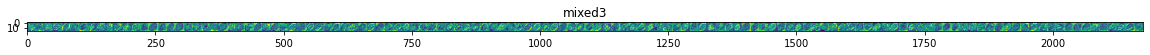

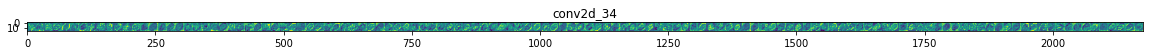

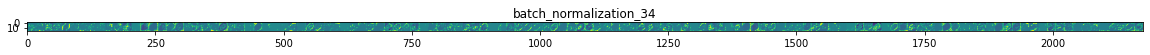

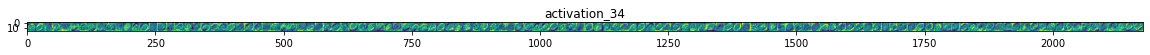

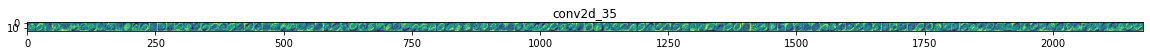

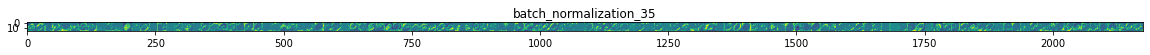

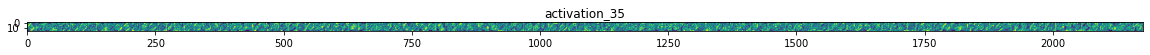

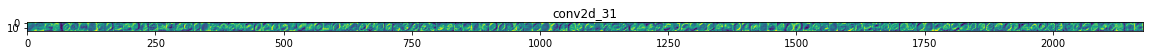

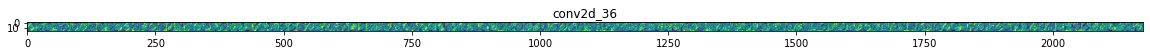

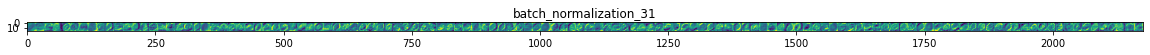

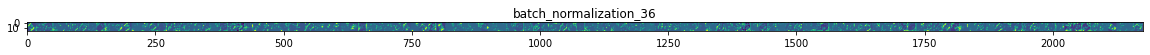

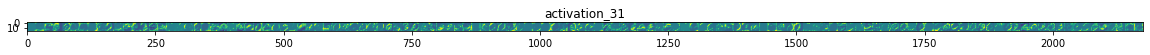

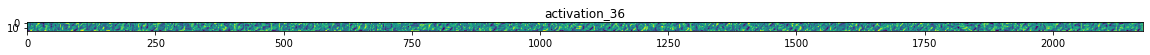

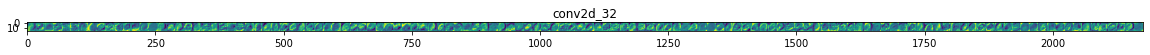

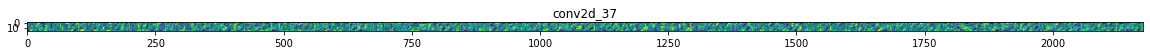

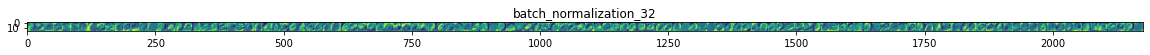

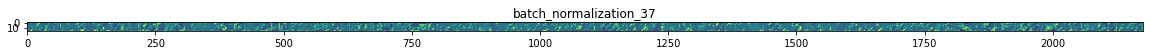

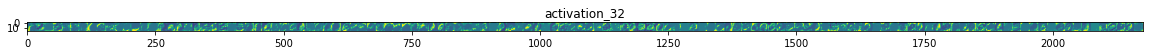

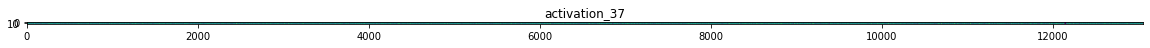

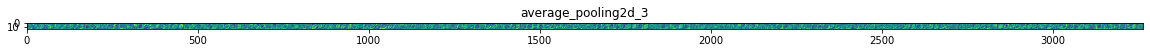

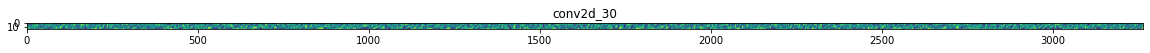

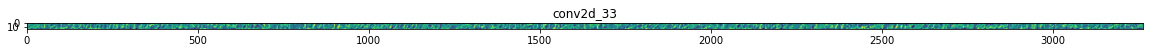

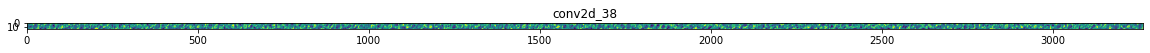

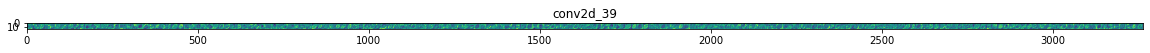

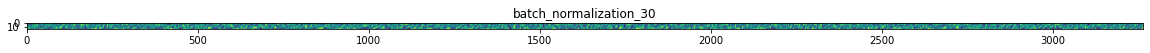

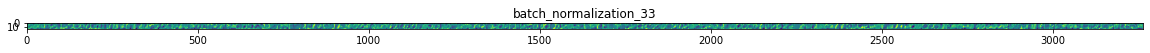

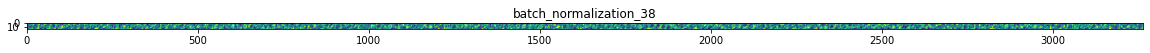

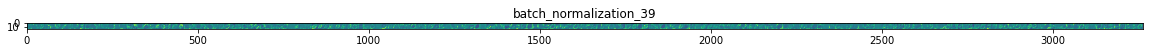

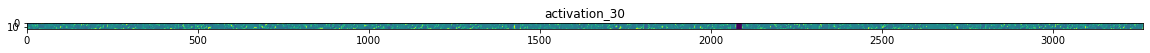

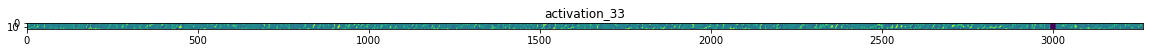

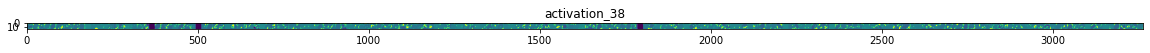

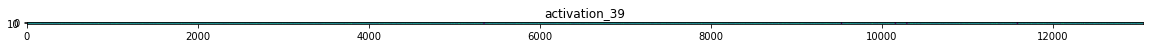

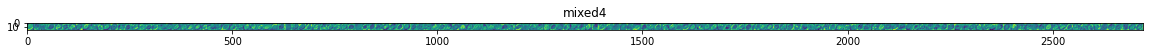

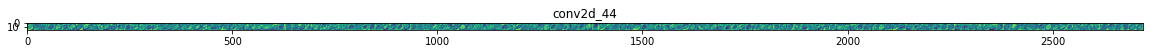

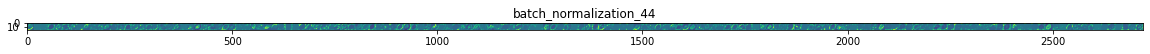

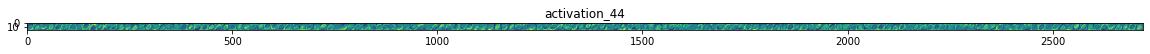

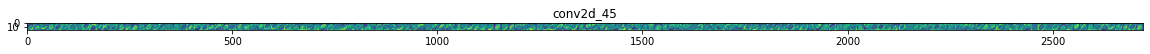

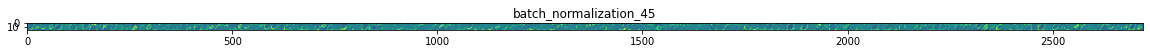

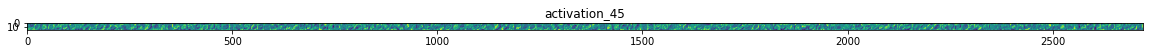

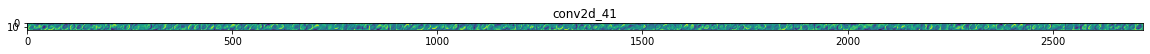

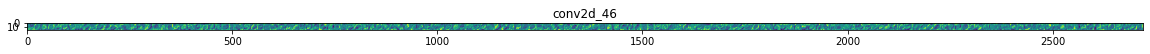

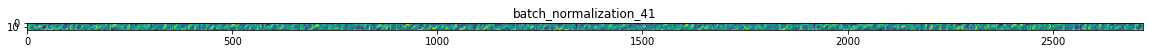

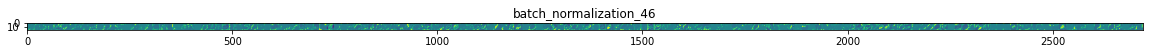

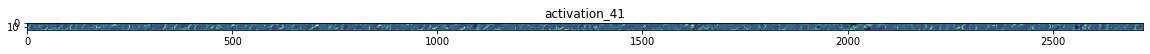

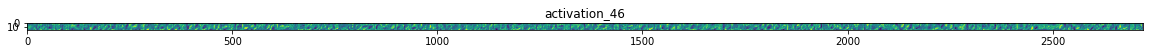

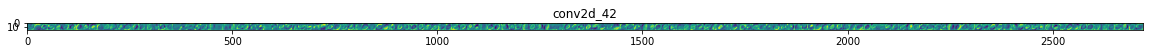

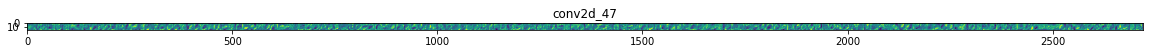

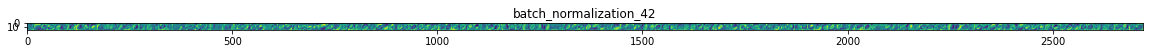

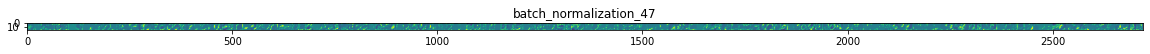

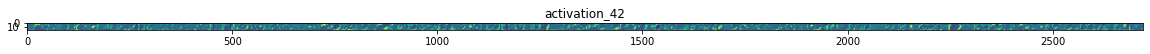

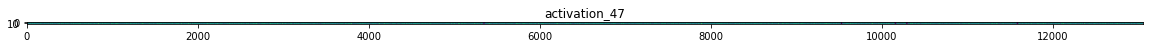

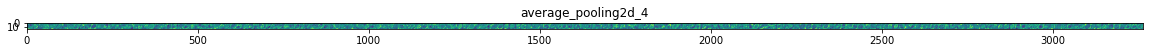

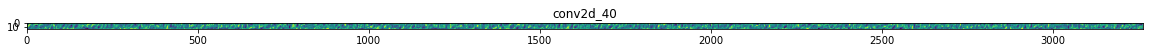

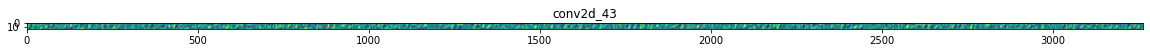

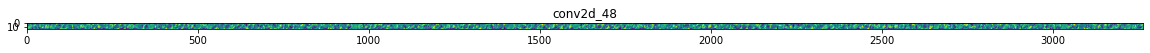

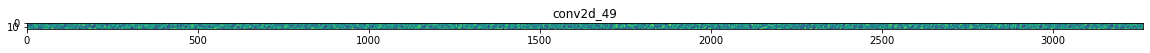

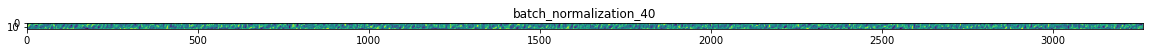

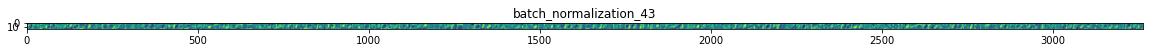

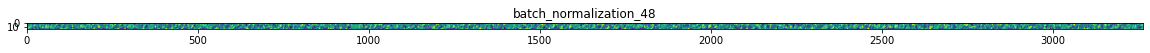

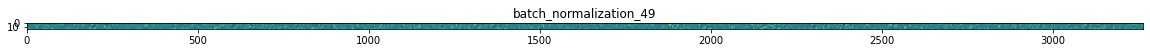

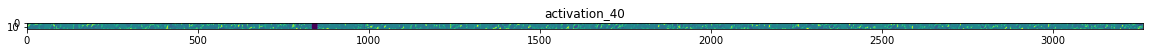

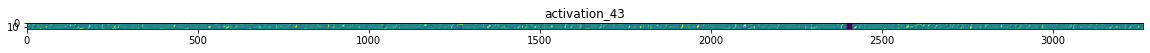

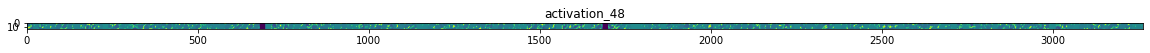

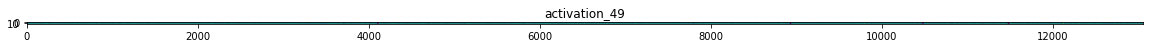

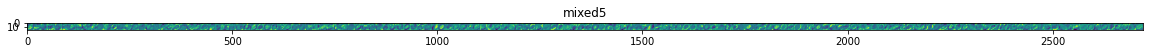

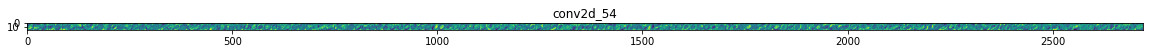

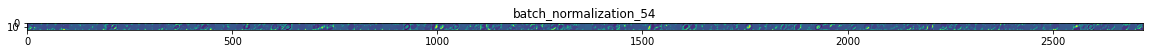

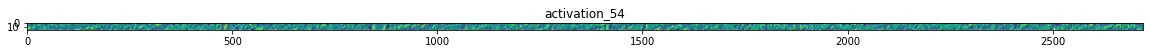

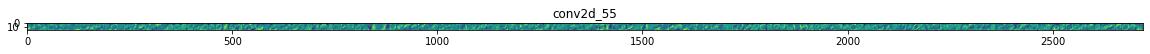

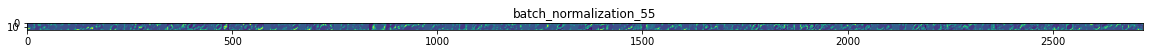

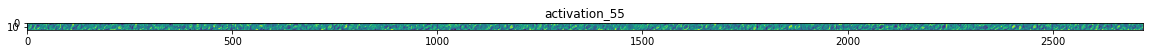

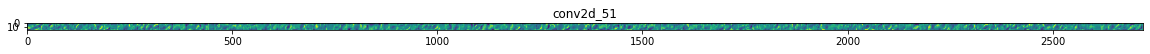

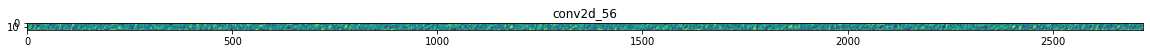

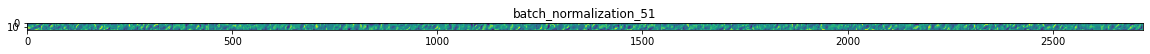

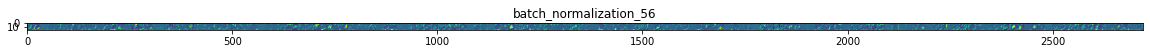

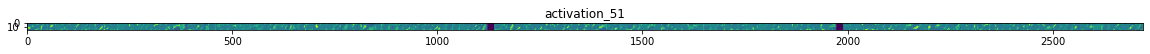

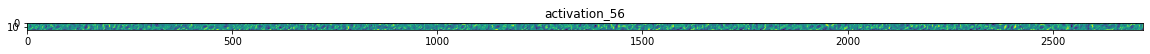

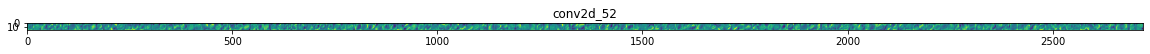

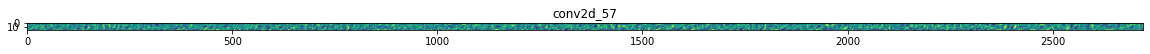

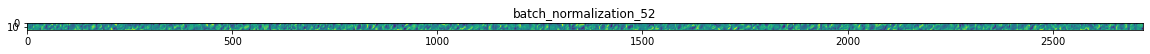

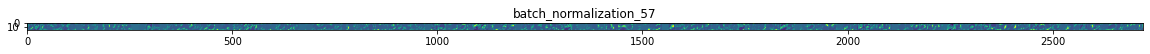

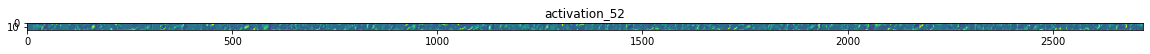

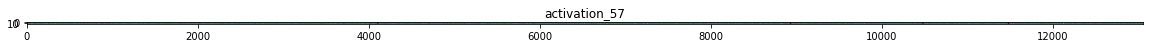

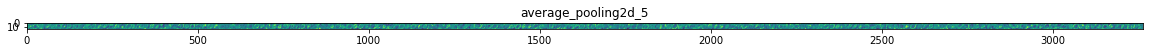

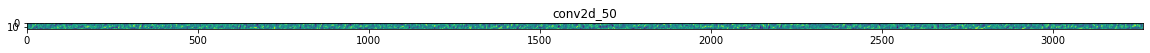

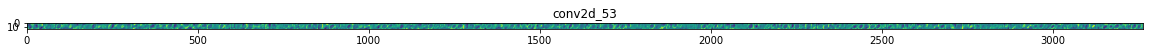

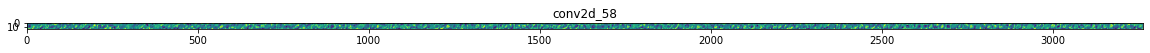

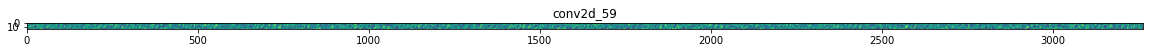

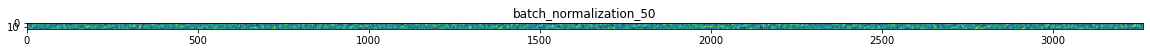

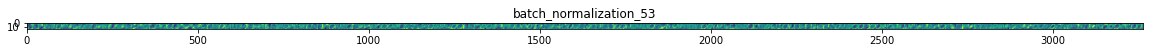

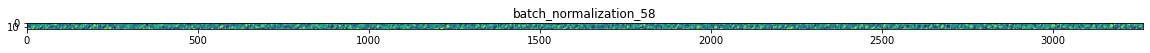

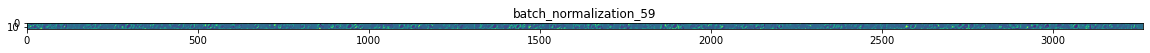

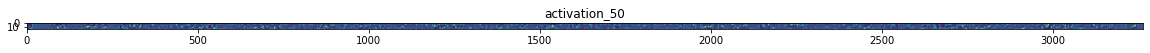

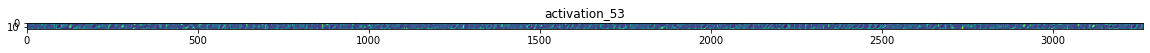

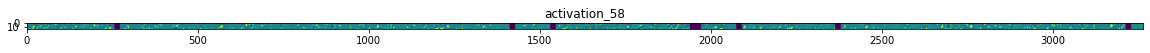

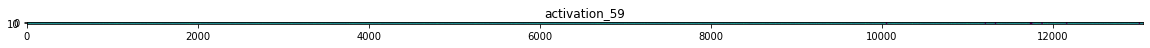

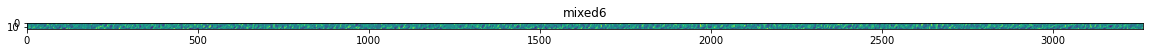

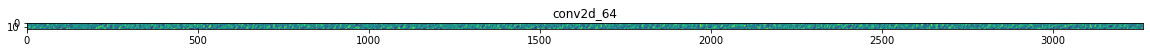

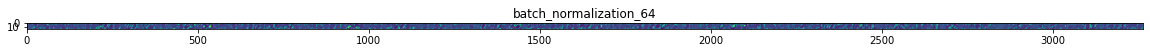

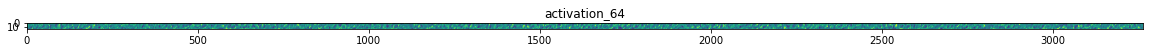

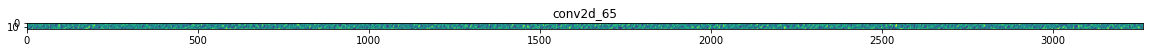

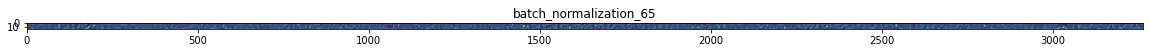

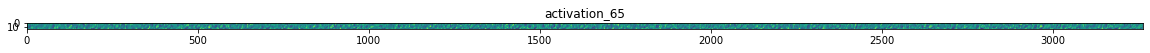

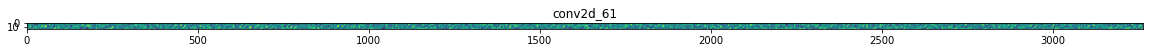

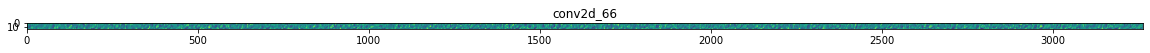

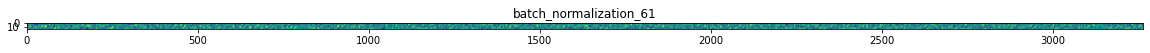

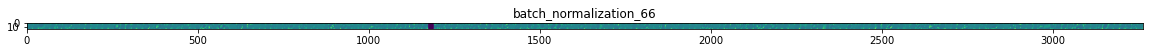

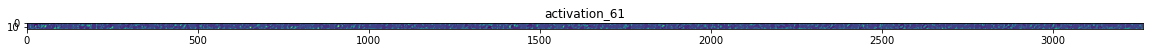

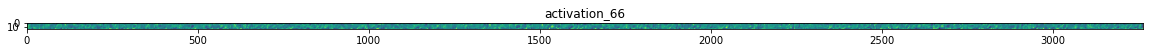

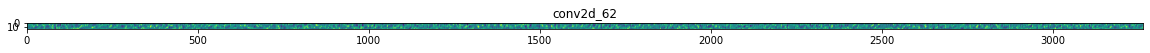

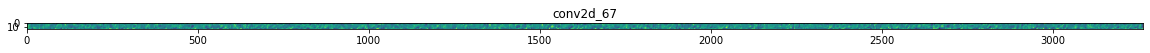

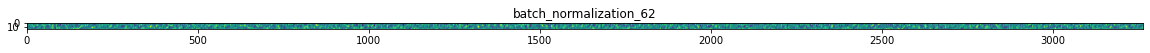

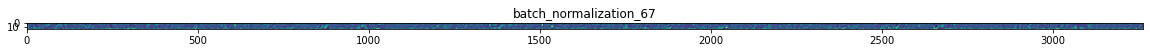

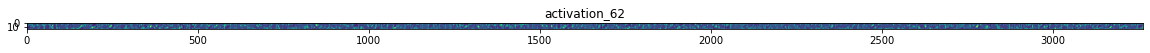

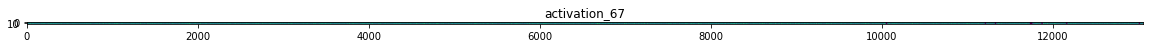

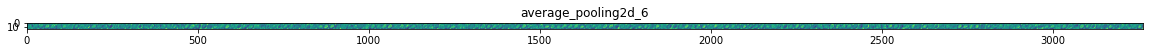

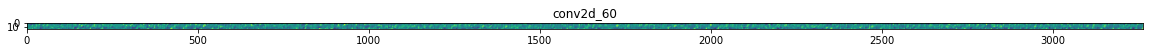

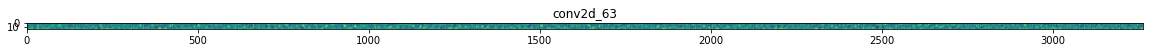

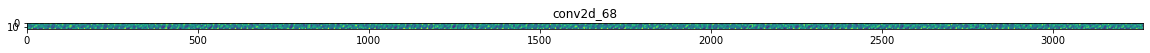

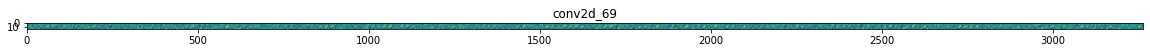

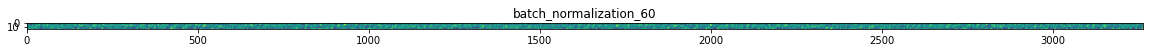

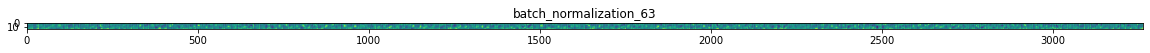

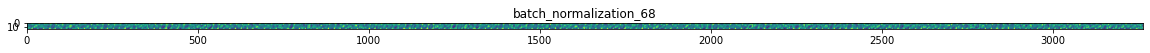

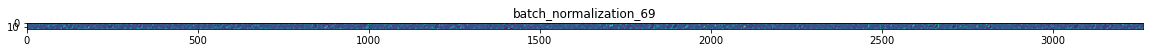

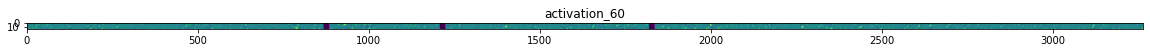

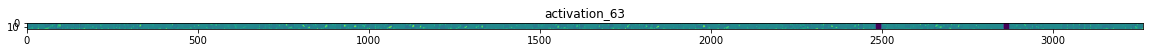

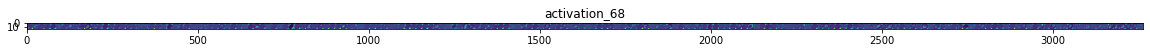

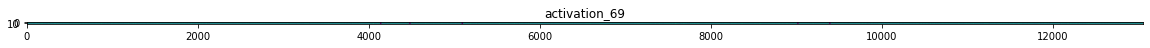

In [ ]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_ampalaya_dir, f) for f in train_ampalaya_dir]
human_img_files = [os.path.join(train_kangkong_dir, f) for f in train_kangkong_dir]
img_path = random.choice(horse_img_files) #+ human_img_files)

img = load_img("/content/gdrive/MyDrive/SinigangMix/train/Ampalaya/Mon Dec 14 17-54-24.jpg", target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

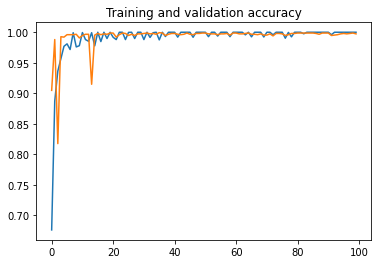

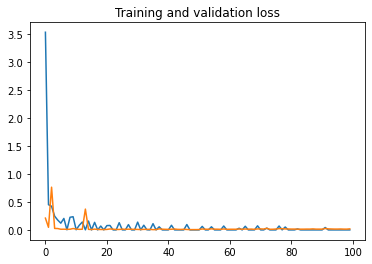

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

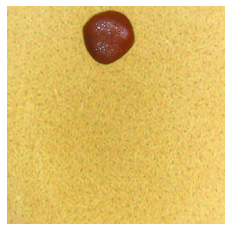

True label: Raddish
Predicted label: Raddish


In [ ]:
#This is the testing process. It will iterate through our real dataset generator to classify images.

from google.colab import files
from keras.preprocessing import image

def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
  #  for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

#x, y = next(tete_generator)
x, y = next(validation_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))


# uploaded = files.upload()
# for fn in uploaded.keys():
#   path = fn
#   img = image.load_img(path, target_size=(300,300))
#   plt.imshow(img)
#   plt.show()
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=8)
#   print(fn)
#   print(classes)=

In [ ]:
#Saving the model
keras_file = "sinigang.h5"
keras.models.save_model(model,keras_file)